### Typhoon Synthetics Dataset





In [ ]:
!pip install openai openpyxl -q

import pandas as pd
import random
import time
import re
from openai import OpenAI
import os
import sys

sys.path.append("/mnt/data")
import sdg_config as config

samples_per_combination = 10
output_file = "typhoon_results.xlsx"
model_name = "typhoon-v2-70b-instruct"

with open("system_prompt.txt", "r", encoding="utf-8") as f:
    system_prompt = f.read().strip()

with open("user_prompt.txt", "r", encoding="utf-8") as f:
    user_prompt_template = f.read().strip()

client = OpenAI(
    api_key="Typhoon_API",
    base_url="https://api.opentyphoon.ai/v1"
)

combinations = []
for label in config.labels:
    for contact in config.contact_chanel:
        for category, types in config.categories_types.items():
            for type_ in types:
                for _ in range(samples_per_combination):
                    combinations.append({
                        "label": label,
                        "contact": contact,
                        "category": category,
                        "type": type_
                    })

if not os.path.exists(output_file):
    pd.DataFrame(columns=["label", "contact", "category", "type", "output", "reasoning", "model"]).to_excel(output_file, index=False)

def get_output_reasoning(prompt):
    try:
        res = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt}
            ]
        )
        text = res.choices[0].message.content
        match = re.search(r"OUTPUT:\s*(.*?)\s*REASONING:\s*(.*)", text, re.DOTALL)
        return (match.group(1).strip(), match.group(2).strip()) if match else ("", "[FAILED TO PARSE]")
    except Exception as e:
        return ("", f"[ERROR] {str(e)}")

total = len(combinations)
for idx, row in enumerate(combinations):
    label = row["label"]
    category = row["category"]

    # --- สุ่ม prompt_data ตาม (category, label) ---
    key = (category, label)
    phrases = config.prompt_data.get(key, {}).get("phrases", [
        "ขออนุญาตสอบถามเพิ่มเติม", "ขอคำแนะนำ", "รบกวนช่วยดูหัวข้อให้หน่อย"
    ])
    prompt_data = random.choice(phrases)

    # --- สุ่ม pronoun ตาม label ---
    pronouns = config.pronouns_by_level.get(label, ["ฉัน", "ผม", "หนู"])
    pronoun = random.choice(pronouns)

    # --- แทนที่ใน template ---
    user_prompt = user_prompt_template.replace("LABEL: พิธีการ", f"LABEL: {label}") \
                                      .replace("CONTACT: Email", f"CONTACT: {row['contact']}") \
                                      .replace("CATEGORY: attendance_issues", f"CATEGORY: {category}") \
                                      .replace("TYPE: request leave", f"TYPE: {row['type']}") \
                                      .replace("OUTPUT:", f"PRONOUN: {pronoun}\nPROMPT_DATA: {prompt_data}\nOUTPUT:")

    output, reasoning = get_output_reasoning(user_prompt)

    new_row = pd.DataFrame([{
        "label": label,
        "contact": row["contact"],
        "category": category,
        "type": row["type"],
        "output": output,
        "reasoning": reasoning,
        "model": model_name
    }])

    with pd.ExcelWriter(output_file, mode="a", engine="openpyxl", if_sheet_exists="overlay") as writer:
        new_row.to_excel(writer, header=False, index=False, startrow=writer.sheets['Sheet1'].max_row)

    print(f"[{idx+1}/{total}] ✅")
    time.sleep(1)


### GPT Cleaning Dataset

In [10]:
import pandas as pd

batch_output = pd.read_json('./batch_6823ed3a1104819084d5eeb5b97556d5_output.jsonl', lines=True)
pd.json_normalize(batch_output['response'])

,status_code,request_id,body.id,body.object,body.created,body.model,body.choices,body.usage.prompt_tokens,body.usage.completion_tokens,body.usage.total_tokens,body.usage.prompt_tokens_details.cached_tokens,body.usage.prompt_tokens_details.audio_tokens,body.usage.completion_tokens_details.reasoning_tokens,body.usage.completion_tokens_details.audio_tokens,body.usage.completion_tokens_details.accepted_prediction_tokens,body.usage.completion_tokens_details.rejected_prediction_tokens,body.service_tier,body.system_fingerprint
0,200,01e8b8e5a6d194d846b5a81f6edf5427,chatcmpl-BX0Q8Kaou1yGOL725fRni1NItgG40,chat.completion,1747206140,gpt-4.1-2025-04-14,"[{'index': 0, 'message': {'role': 'assistant',...",2077,379,2456,0,0,0,0,0,0,default,fp_b38e740b47
1,200,490a7351134f0af0c231416db1cdb7fc,chatcmpl-BWzIGxiKIAXxS53cenAbNhElr2nNb,chat.completion,1747201808,gpt-4.1-2025-04-14,"[{'index': 0, 'message': {'role': 'assistant',...",2075,218,2293,0,0,0,0,0,0,default,fp_b8b3f86f2b
2,200,f3e4ac104bd8aeabd090fe8c4a19b903,chatcmpl-BWzIJs4MNPsF2lDAoSmnG4kO7rGcg,chat.completion,1747201811,gpt-4.1-2025-04-14,"[{'index': 0, 'message': {'role': 'assistant',...",2077,260,2337,0,0,0,0,0,0,default,fp_b8b3f86f2b
3,200,dd8ff29f3d5b917ae39f17a4c4324f79,chatcmpl-BWzIOK1SaVIp8xmHu77AzOZkoyTxC,chat.completion,1747201816,gpt-4.1-2025-04-14,"[{'index': 0, 'message': {'role': 'assistant',...",2077,185,2262,0,0,0,0,0,0,default,fp_b38e740b47
4,200,c234f9030cc0f7d4066c300be57a1948,chatcmpl-BWzIQYo8FvRqD8qPONpwImVrXqmMq,chat.completion,1747201818,gpt-4.1-2025-04-14,"[{'index': 0, 'message': {'role': 'assistant',...",2075,165,2240,0,0,0,0,0,0,default,fp_b8b3f86f2b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,200,9ea28202206805021058bf6272206176,chatcmpl-BWzKIxfRNqmTFUUOac927RgqsmVv8,chat.completion,1747201934,gpt-4.1-2025-04-14,"[{'index': 0, 'message': {'role': 'assistant',...",2077,227,2304,0,0,0,0,0,0,default,fp_a1102cf978
2496,200,9571ef88437aa01d0c020ba516960170,chatcmpl-BWzKNw862arajZqFyHikcn9AH5H1P,chat.completion,1747201939,gpt-4.1-2025-04-14,"[{'index': 0, 'message': {'role': 'assistant',...",2075,213,2288,0,0,0,0,0,0,default,fp_beec22d258
2497,200,5b2f2cb4a34f14e46e343decfc656f14,chatcmpl-BWzKKdYBAIKNJtytpFUIjcIRjHc7L,chat.completion,1747201936,gpt-4.1-2025-04-14,"[{'index': 0, 'message': {'role': 'assistant',...",2077,220,2297,0,0,0,0,0,0,default,fp_b38e740b47
2498,200,89bef08f08ee28ff163ed621534ab918,chatcmpl-BWzKOAJjFaes00LYVdPJW6eFgAZqA,chat.completion,1747201940,gpt-4.1-2025-04-14,"[{'index': 0, 'message': {'role': 'assistant',...",2077,222,2299,0,0,0,0,0,0,default,fp_3b5c2e113e


In [11]:
batch_output = pd.read_json('./batch_6823ed3a1104819084d5eeb5b97556d5_output.jsonl', lines=True)
body_flatten = pd.json_normalize(batch_output['response'])
choices_flatten = pd.json_normalize(body_flatten['body.choices'])
choices_flatten_2ndlayer = pd.json_normalize(choices_flatten[0])

batch_output['output_prompt'] = choices_flatten_2ndlayer['message.content']
batch_output.drop(columns=['error'], inplace=True)
batch_output['body.model'] = body_flatten['body.model']

batch_output['main_output'] = batch_output['output_prompt'].str.split('REASONING: ').str[0]
batch_output['reasoning_output'] = "REASONING: " + batch_output['output_prompt'].str.split('REASONING: ').str[-1]

batch_output

,id,custom_id,response,output_prompt,body.model,main_output,reasoning_output
0,batch_req_6824402e85a481908875c269d2a5a5fa,0_Email_พิธีการ_academic_advice_project consul...,"{'status_code': 200, 'request_id': '01e8b8e5a6...",OUTPUT: ข้าพระพุทธเจ้าขอกราบเรียนมายังท่านศาสต...,gpt-4.1-2025-04-14,OUTPUT: ข้าพระพุทธเจ้าขอกราบเรียนมายังท่านศาสต...,REASONING: ข้อความนี้เป็นภาษาระดับพิธีการ เพรา...
1,batch_req_6824402ea5d08190992eb9332349dda1,0_Email_ทางการ_academic_advice_project consult...,"{'status_code': 200, 'request_id': '490a735113...",OUTPUT: เรียนอาจารย์ที่เคารพ กระผมมีข้อสงสัยเก...,gpt-4.1-2025-04-14,OUTPUT: เรียนอาจารย์ที่เคารพ กระผมมีข้อสงสัยเก...,REASONING: ข้อความนี้ใช้ภาษาที่สุภาพและเป็นทาง...
2,batch_req_6824402ec6688190933b867f54d427ac,0_Email_กึ่งทางการ_academic_advice_project con...,"{'status_code': 200, 'request_id': 'f3e4ac104b...",OUTPUT: สวัสดีค่ะอาจารย์ หนูมีข้อสงสัยเกี่ยวกั...,gpt-4.1-2025-04-14,OUTPUT: สวัสดีค่ะอาจารย์ หนูมีข้อสงสัยเกี่ยวกั...,REASONING: ข้อความนี้ใช้ภาษาที่สุภาพและเป็นมิต...
3,batch_req_6824402ef2e88190a0e9dddf992b5294,0_Email_ไม่เป็นทางการ_academic_advice_project ...,"{'status_code': 200, 'request_id': 'dd8ff29f3d...",OUTPUT: อาจารย์คะ หนูมีเรื่องโปรเจกต์อยากปรึกษ...,gpt-4.1-2025-04-14,OUTPUT: อาจารย์คะ หนูมีเรื่องโปรเจกต์อยากปรึกษ...,REASONING: This text uses informal but polite ...
4,batch_req_6824402f19c881908721c20be29c2f1b,0_Email_กันเอง_academic_advice_project consult...,"{'status_code': 200, 'request_id': 'c234f9030c...",OUTPUT: อาจารย์ๆ ช่วยดูโปรเจกต์หน่อยดิ ตรงนี้ห...,gpt-4.1-2025-04-14,OUTPUT: อาจารย์ๆ ช่วยดูโปรเจกต์หน่อยดิ ตรงนี้ห...,REASONING: This text is highly informal and us...
...,...,...,...,...,...,...,...
2495,batch_req_682441db185081909a28aecb9b73faff,4_Chat_พิธีการ_gratitude_respect_final thanks,"{'status_code': 200, 'request_id': '9ea2820220...",OUTPUT: ข้าพระพุทธเจ้าขอกราบแสดงความขอบพระคุณต...,gpt-4.1-2025-04-14,OUTPUT: ข้าพระพุทธเจ้าขอกราบแสดงความขอบพระคุณต...,REASONING: This text uses highly ritualistic a...
2496,batch_req_682441db3e088190b3c7c25987df517c,4_Chat_ทางการ_gratitude_respect_final thanks,"{'status_code': 200, 'request_id': '9571ef8843...",OUTPUT: กระผมขอแสดงความขอบคุณต่ออาจารย์เป็นอย่...,gpt-4.1-2025-04-14,OUTPUT: กระผมขอแสดงความขอบคุณต่ออาจารย์เป็นอย่...,REASONING: ข้อความนี้ใช้ถ้อยคำที่สุภาพและเป็นท...
2497,batch_req_682441db68a88190b588196d506d7b8b,4_Chat_กึ่งทางการ_gratitude_respect_final thanks,"{'status_code': 200, 'request_id': '5b2f2cb4a3...",OUTPUT: อาจารย์คะ หนูขอขอบคุณอาจารย์มากๆ เลยนะ...,gpt-4.1-2025-04-14,OUTPUT: อาจารย์คะ หนูขอขอบคุณอาจารย์มากๆ เลยนะ...,REASONING: ข้อความนี้ใช้ภาษาที่สุภาพแต่ไม่เป็น...
2498,batch_req_682441db8efc8190a4d57ea564f0c72c,4_Chat_ไม่เป็นทางการ_gratitude_respect_final t...,"{'status_code': 200, 'request_id': '89bef08f08...",OUTPUT: ขอบคุณมากๆ เลยนะคะอาจารย์ ที่ช่วยแนะนำ...,gpt-4.1-2025-04-14,OUTPUT: ขอบคุณมากๆ เลยนะคะอาจารย์ ที่ช่วยแนะนำ...,REASONING: ข้อความนี้ใช้ภาษาที่เป็นกันเองและเข...


Export to excel

In [ ]:
df = batch_output.drop(['id','response','output_prompt'], axis = 1)

columns = ['label', 'contact', 'category', 'type', 'output', 'reasoning','model']

gpt_output = pd.DataFrame(columns=columns)
gpt_output

In [ ]:
split_cols = df['custom_id'].str.split('_', expand=True)

split_cols.columns = ['index', 'contact', 'label', 'category', 'category1', 'type']

split_cols['category'] = split_cols['category'] + ' ' + split_cols['category1']

split_cols = split_cols.drop('category1', axis=1)

split_cols

In [ ]:
gpt_output['reasoning'] = df['reasoning_output']
gpt_output['output'] = df['main_output']
gpt_output['model'] = df['body.model']
gpt_output['label'] = split_cols['label']
gpt_output['contact'] = split_cols['contact']
gpt_output['category'] = split_cols['category']
gpt_output['type'] = split_cols['type']

gpt_output['output'] = gpt_output['output'].str.replace('^OUTPUT:\s*', '', regex=True)

gpt_output['reasoning'] = gpt_output['reasoning'].str.replace('^REASONING:\s*', '', regex=True)

gpt_output

In [ ]:
gpt_output.to_excel('gpt_output.xlsx', index=False)

### Final Dataset

In [ ]:
import os
import pandas as pd

file_list = os.listdir("./")
xlsx_file_list = [file_name for file_name in file_list if file_name.endswith(".xlsx")]

Data = pd.DataFrame()
for xlsx_file in xlsx_file_list:
    Data_temp = pd.read_excel(xlsx_file)
    Data = pd.concat([Data, Data_temp], ignore_index=True).dropna()

In [ ]:
Data['category'] = Data['category'].str.replace('_', ' ', regex=False)
Data['output'] = Data['output'].str.replace(',', ' ', regex=False)
Data

,label,contact,category,type,output,reasoning,model
0,พิธีการ,Email,academic advice,project consultation,ข้าพระพุทธเจ้าเกล้ากระหม่อมขอน้อมรับพระบรมราโช...,"This text is highly ceremonial and formal, usi...",typhoon-v2-70b-instruct
1,พิธีการ,Email,academic advice,project consultation,หม่อมฉันขอถวายรายงานเกี่ยวกับหัวข้อวิทยานิพนธ์...,"This text is highly ceremonial, using formal a...",typhoon-v2-70b-instruct
2,พิธีการ,Email,academic advice,project consultation,หม่อมฉันขอกราบเรียนอาจารย์ด้วยความเคารพอย่างสู...,"This text is highly ceremonial and formal, usi...",typhoon-v2-70b-instruct
3,พิธีการ,Email,academic advice,project consultation,ข้าพระพุทธเจ้าใคร่ขอกราบเรียนคณาจารย์ที่เคารพอ...,"This text is highly ceremonial and formal, usi...",typhoon-v2-70b-instruct
4,พิธีการ,Email,academic advice,project consultation,ข้าพระพุทธเจ้าใคร่ขอกราบเรียนศาสตราจารย์ด้วยคว...,"This text is highly ceremonial and formal, usi...",typhoon-v2-70b-instruct
...,...,...,...,...,...,...,...
42199,พิธีการ,Chat,gratitude respect,final thanks,ข้าพระพุทธเจ้าขอกราบแสดงความขอบพระคุณต่อท่านอา...,This text uses highly ritualistic and formal l...,gpt-4.1-2025-04-14
42200,ทางการ,Chat,gratitude respect,final thanks,กระผมขอแสดงความขอบคุณต่ออาจารย์เป็นอย่างยิ่งสำ...,ข้อความนี้ใช้ถ้อยคำที่สุภาพและเป็นทางการ เช่น ...,gpt-4.1-2025-04-14
42201,กึ่งทางการ,Chat,gratitude respect,final thanks,อาจารย์คะ หนูขอขอบคุณอาจารย์มากๆ เลยนะคะ สำหรั...,ข้อความนี้ใช้ภาษาที่สุภาพแต่ไม่เป็นทางการเต็มท...,gpt-4.1-2025-04-14
42202,ไม่เป็นทางการ,Chat,gratitude respect,final thanks,ขอบคุณมากๆ เลยนะคะอาจารย์ ที่ช่วยแนะนำและให้กำ...,ข้อความนี้ใช้ภาษาที่เป็นกันเองและเข้าใจง่าย เช...,gpt-4.1-2025-04-14


In [ ]:
Data.to_excel('Final_Data.xlsx', index=False)

For hugging face

In [8]:
Data.drop(columns=['contact','type'], inplace=True)
#Data

In [9]:
Data.to_csv('Final_Data.csv', index=False)

### EDA Data

In [ ]:
!pip install -U datasets

In [12]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("nnudee/Thai-Thangkarn-sentence", split = 'train')
ds = ds.to_pandas()
ds

Final_Data-3.csv:   0%|          | 0.00/42.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/42204 [00:00<?, ? examples/s]

,label,category,output,reasoning,model
0,พิธีการ,academic advice,ข้าพระพุทธเจ้าเกล้ากระหม่อมขอน้อมรับพระบรมราโช...,"This text is highly ceremonial and formal, usi...",typhoon-v2-70b-instruct
1,พิธีการ,academic advice,หม่อมฉันขอถวายรายงานเกี่ยวกับหัวข้อวิทยานิพนธ์...,"This text is highly ceremonial, using formal a...",typhoon-v2-70b-instruct
2,พิธีการ,academic advice,หม่อมฉันขอกราบเรียนอาจารย์ด้วยความเคารพอย่างสู...,"This text is highly ceremonial and formal, usi...",typhoon-v2-70b-instruct
3,พิธีการ,academic advice,ข้าพระพุทธเจ้าใคร่ขอกราบเรียนคณาจารย์ที่เคารพอ...,"This text is highly ceremonial and formal, usi...",typhoon-v2-70b-instruct
4,พิธีการ,academic advice,ข้าพระพุทธเจ้าใคร่ขอกราบเรียนศาสตราจารย์ด้วยคว...,"This text is highly ceremonial and formal, usi...",typhoon-v2-70b-instruct
...,...,...,...,...,...
42199,พิธีการ,gratitude respect,ข้าพระพุทธเจ้าขอกราบแสดงความขอบพระคุณต่อท่านอา...,This text uses highly ritualistic and formal l...,gpt-4.1-2025-04-14
42200,ทางการ,gratitude respect,กระผมขอแสดงความขอบคุณต่ออาจารย์เป็นอย่างยิ่งสำ...,ข้อความนี้ใช้ถ้อยคำที่สุภาพและเป็นทางการ เช่น ...,gpt-4.1-2025-04-14
42201,กึ่งทางการ,gratitude respect,อาจารย์คะ หนูขอขอบคุณอาจารย์มากๆ เลยนะคะ สำหรั...,ข้อความนี้ใช้ภาษาที่สุภาพแต่ไม่เป็นทางการเต็มท...,gpt-4.1-2025-04-14
42202,ไม่เป็นทางการ,gratitude respect,ขอบคุณมากๆ เลยนะคะอาจารย์ ที่ช่วยแนะนำและให้กำ...,ข้อความนี้ใช้ภาษาที่เป็นกันเองและเข้าใจง่าย เช...,gpt-4.1-2025-04-14


In [17]:
columns_to_count = ["label", "contact", "category", "type", "model"]

for col in columns_to_count:
    print(ds[col].value_counts())


label
ทางการ           8500
ไม่เป็นทางการ    8500
กึ่งทางการ       8500
พิธีการ          8498
กันเอง           8206
Name: count, dtype: int64
contact
Email    21236
Chat     20968
Name: count, dtype: int64
category
attendance issues           8500
academic advice             8482
submission notifications    8438
document requests           8396
gratitude respect           8388
Name: count, dtype: int64
type
revision discussion          850
outline clarification        850
personal leave               850
unexpected issue             850
sick leave                   850
absence notification         850
early leave                  850
late arrival                 850
class absence                850
request leave                850
delay in assignment          850
late submission              850
inform absence in advance    850
extension request            850
urgent matter                850
topic approval               849
submission issue             849
research help               

Typhoon - EDA

In [21]:
data = ds[ds['model'] == 'typhoon-v2-70b-instruct']

#Email - Chat

labels = data['label'].unique()

for label in labels:
    print(f"\n=== Label: {label} ===")

    print("Email ตัวอย่าง:")
    email_examples = data[(data['label'] == label) & (data['contact'] == 'Email')].sample(n=5, random_state=42)
    for text in email_examples['output']:
        print("-", text)

    print("Chat ตัวอย่าง:")
    chat_examples = data[(data['label'] == label) & (data['contact'] == 'Chat')].sample(n=5, random_state=42)
    for text in chat_examples['output']:
        print("-", text)


=== Label: พิธีการ ===
Email ตัวอย่าง:
- ข้าพระพุทธเจ้าใคร่ขอกราบเรียนอาจารย์ด้วยความเคารพอย่างสูง เนื่องด้วยกระหม่อมมีปัญหาบางประการในการดำเนินการส่งงาน ทำให้กระหม่อมไม่สามารถส่งงานได้ภายในระยะเวลาที่กำหนด จึงใคร่ขอความกรุณาอาจารย์โปรดพิจารณาอนุญาตให้กระหม่อมส่งงานในภายหลัง ด้วยจักเป็นพระกรุณาอย่างหาที่สุดมิได้
- ท่านอาจารย์ที่เคารพอย่างสูง ข้าพเจ้าใคร่ขอกราบเรียนท่านอาจารย์ด้วยความเคารพอย่างสูง เนื่องด้วยข้าพเจ้ามีความประสงค์ขอพระราชทานวุฒิบัตร ข้าพเจ้าจึงใคร่ขอความกรุณาท่านอาจารย์โปรดพิจารณาอนุเคราะห์ในการดำเนินการดังกล่าวด้วยจักเป็นพระกรุณาอย่างหาที่สุดมิได้
- ข้าพระพุทธเจ้าใคร่ขอกราบเรียนอาจารย์ด้วยความเคารพอย่างสูง เนื่องด้วยข้าพเจ้าได้ส่งเอกสารที่เกี่ยวข้องล่าช้าไป ข้าพเจ้าจึงใคร่ขอความกรุณาอาจารย์โปรดพิจารณาอนุญาตให้ข้าพเจ้าสามารถส่งเอกสารดังกล่าวใหม่ได้ในโอกาสนี้ ด้วยจักเป็นพระกรุณาอย่างหาที่สุดมิได้
- ข้าพระพุทธเจ้าใคร่ขอกราบเรียนคณาจารย์ด้วยความเคารพอย่างสูง เนื่องด้วยเหตุการณ์ไม่คาดคิดที่เกิดขึ้น ข้าพเจ้าจึงมีความจำเป็นต้องขอประทานโอกาสงดเข้าศึกษาเป็นกรณีพิเศษในระยะเวลานี้

In [ ]:
#Each Label

labels = data['label'].unique()

for label in labels:
    print(f"\n=== Label: {label} ===")

    for text in data[data['label'] == label ]['output'].sample(n=5, random_state=42):
        print("-", text)


=== Label: พิธีการ ===
- ข้าพเจ้าใคร่ขอพระราชทานแสดงความซาบซึ้งในพระมหากรุณาธิคุณอันล้นพ้น ที่ทรงมีต่อข้าพเจ้าอย่างหาที่สุดมิได้ ด้วยความเคารพและสำนึกในพระมหากรุณาธิคุณอย่างสูงสุด ข้าพเจ้าขอพระราชทานกราบถวายความนับถืออย่างสูง
- ข้าพระพุทธเจ้าใคร่ขอกราบเรียนคณาจารย์ด้วยความเคารพอย่างสูง ข้าพเจ้ามีความประสงค์ขอพระราชทานชี้แนะเกี่ยวกับการปรับปรุงงานวิจัยที่ได้จัดทำขึ้น เพื่อให้สามารถพัฒนาและเสริมสร้างความรู้ให้มีความสมบูรณ์ยิ่งขึ้น ข้าพเจ้าใคร่ขอความกรุณาคณาจารย์โปรดชี้แนะแนวทางในการปรับปรุงงานดังกล่าว ด้วยจักเป็นพระกรุณาอย่างหาที่สุดมิได้
- หม่อมฉันขอพระราชทานกราบบังคมทูลลาเข้าร่วมการประชุมในวันพรุ่งนี้ เนื่องด้วยมีเหตุการณ์สำคัญที่ต้องเข้าร่วมอย่างไม่อาจหลีกเลี่ยงได้ หม่อมฉันขอพระราชทานกราบบังคมทูลขออภัยในความไม่สะดวกที่เกิดขึ้น และขอพระราชทานกราบบังคมทูลขออนุญาตล่วงหน้า ด้วยความเคารพอย่างสูง
- ข้าพระพุทธเจ้าใคร่ขอกราบเรียนคณาจารย์ด้วยความเคารพอย่างสูง ขอแสดงมุทิตาจิตและความนับถืออย่างยิ่ง ต่อความเมตตาและความรู้ที่ท่านได้ถ่ายทอดให้แก่ข้าพระพุทธเจ้า ด้วยจักเป็นพระกรุณาอย่างหาที่สุดมิได้

In [31]:
labels = ds["label"].unique()
types = ds["type"].unique()

for label in labels:
    for t in types:
        subset = ds[(ds["label"] == label) & (ds["type"] == t)]
        if len(subset) >= 3:
            examples = subset.sample(3, random_state=42).reset_index(drop=True)
            print(f"\n Label: {label} |  Type: {t}")
            for i, row in examples.iterrows():
                print(f"\n- {row['output']}")


 Label: พิธีการ |  Type: project consultation

- ข้าพระพุทธเจ้าขอกราบเรียนอาจารย์ด้วยความเคารพอย่างสูง หม่อมฉันมีความประสงค์จะขอถวายรายงานหัวข้อวิทยานิพนธ์ เพื่อให้อาจารย์ได้โปรดพิจารณาและให้คำแนะนำในเรื่องที่เกี่ยวข้อง หากมีข้อสงสัยหรือข้อเสนอแนะใด ๆ หม่อมฉันยินดีที่จะรับฟังและนำไปปรับปรุงต่อไป ด้วยจักเป็นพระกรุณาอย่างหาที่สุดมิได้

- ข้าพระพุทธเจ้าใคร่ขอกราบเรียนอาจารย์ด้วยความเคารพอย่างสูง ข้าพเจ้ามีความประสงค์ขอพระราชทานโอกาสเข้าพบอาจารย์เพื่อขอคำปรึกษาเกี่ยวกับโครงการศึกษาที่กำลังดำเนินการอยู่ ข้าพเจ้าใคร่ขอความกรุณาอาจารย์โปรดพิจารณาอนุญาตให้ข้าพเจ้าเข้าพบเพื่อขอคำแนะนำด้วยจักเป็นพระกรุณาอย่างหาที่สุดมิได้

- ข้าพระพุทธเจ้าใคร่ขอกราบเรียนอาจารย์ด้วยความเคารพอย่างสูง ข้าพเจ้าใคร่ขอพระราชทานชี้แนะเกี่ยวกับโครงการที่กำลังดำเนินการอยู่ในขณะนี้ เพื่อให้การดำเนินงานเป็นไปอย่างถูกต้องและเหมาะสม ด้วยจักเป็นพระกรุณาอย่างหาที่สุดมิได้

 Label: พิธีการ |  Type: thesis guidance

- ข้าพระพุทธเจ้ากระหม่อมใคร่ขอกราบเรียนอาจารย์ด้วยความเคารพอย่างสูง ข้าพระพุทธเจ้ากระหม่อมมีความประสงค์ที่จะขอรับ

gpt-4.1

In [ ]:
data = ds[ds['model'] == 'gpt-4.1-2025-04-14']

#Email - Chat

labels = data['label'].unique()

for label in labels:
    print(f"\n=== Label: {label} ===")

    print("Email ตัวอย่าง:")
    email_examples = data[(data['label'] == label) & (data['contact'] == 'Email')].sample(n=5, random_state=42)
    for text in email_examples['output']:
        print("-", text)

    print("Chat ตัวอย่าง:")
    chat_examples = data[(data['label'] == label) & (data['contact'] == 'Chat')].sample(n=5, random_state=42)
    for text in chat_examples['output']:
        print("-", text)


=== Label: พิธีการ ===
Email ตัวอย่าง:
- ข้าพเจ้าใคร่ขอกราบเรียนแสดงความเคารพอย่างสูงสุดมายังท่านอาจารย์ผู้ทรงคุณวุฒิ ด้วยสำนึกในพระคุณและความเมตตาที่ท่านกรุณาอบรมสั่งสอนและให้โอกาสข้าพเจ้าในการศึกษาเล่าเรียน ข้าพเจ้าขอน้อมรำลึกถึงพระคุณและจะน้อมนำคำสอนของท่านเป็นแนวทางในการดำเนินชีวิตต่อไปด้วยความเคารพอย่างหาที่สุดมิได้ ขอกราบขอบพระคุณยิ่งมา ณ โอกาสนี้


- ข้าพระพุทธเจ้าขอกราบเรียนมายังท่านอาจารย์ผู้ทรงคุณวุฒิ ด้วยความเคารพอย่างสูงว่า ตามที่ข้าพเจ้าขอส่งข้อเสนอโครงการวิจัยเพื่อขอรับคำแนะนำจากท่านนั้น ข้าพเจ้าขอความกรุณาโปรดพิจารณาตรวจสอบข้อเสนอดังกล่าว หากมีข้อเสนอแนะหรือประเด็นใดที่ควรปรับปรุง ข้าพเจ้าขอน้อมรับด้วยความยินดีและจะนำไปดำเนินการแก้ไขโดยเคร่งครัด ขอแสดงความนับถืออย่างสูง


- ข้าพเจ้าใคร่ขอกราบแสดงความเคารพอย่างสูงสุดต่อท่านอาจารย์ผู้ทรงคุณวุฒิ ด้วยความสำนึกในพระคุณและความเมตตาที่ท่านได้ประทานความรู้และแนะนำแนวทางแห่งปัญญาตลอดระยะเวลาที่ผ่านมา ข้าพเจ้าขอนอบน้อมขอบพระคุณเป็นล้นพ้น และขอกราบเรียนแสดงความเคารพด้วยใจจริงยิ่ง

- ข้าพเจ้าใคร่ขอกราบเรียนมายังท่านอาจารย์ผู้ทรงคุณ

In [ ]:
#Each Label

labels = data['label'].unique()

for label in labels:
    print(f"\n=== Label: {label} ===")

    for text in data[data['label'] == label ]['output'].sample(n=5, random_state=42):
        print("-", text)


=== Label: พิธีการ ===
- ข้าพระพุทธเจ้าใคร่ขอกราบเรียนท่านอาจารย์ผู้ทรงคุณวุฒิด้วยความเคารพอย่างสูงว่า ข้าพเจ้ามีเหตุจำเป็นอันมิอาจหลีกเลี่ยงได้ ซึ่งส่งผลให้ไม่สามารถเข้าร่วมการเรียนการสอนได้ตามกำหนดเวลา จึงขอกราบอภัยและน้อมรับในความผิดพลาดนี้ ด้วยความเคารพอย่างยิ่ง ขอกราบเรียนมาเพื่อโปรดทราบและอนุเคราะห์

- ข้าพระพุทธเจ้าขอกราบเรียนท่านอาจารย์ผู้ทรงคุณวุฒิด้วยความเคารพอย่างสูง ว่าข้าพเจ้าประสบปัญหาขัดข้องทางเทคนิคอันมิอาจหลีกเลี่ยง ส่งผลให้ไม่สามารถดำเนินการส่งผลงานได้ตามกำหนดเวลา จึงขอกราบขอประทานอภัย และขอความกรุณาท่านโปรดพิจารณาอนุเคราะห์แนะแนวทางการดำเนินการต่อไปด้วยความเคารพยิ่ง


- ข้าพระพุทธเจ้าขอกราบเรียนแจ้งมายังท่านอาจารย์ผู้ทรงคุณวุฒิด้วยความเคารพยิ่งว่า เนื่องด้วยข้าพเจ้าประสบปัญหาขัดข้องทางเทคนิคในระบบส่งงานออนไลน์ ส่งผลให้ไม่สามารถดำเนินการส่งงานได้ภายในระยะเวลาที่กำหนด จึงขอกราบอภัยมา ณ โอกาสนี้ และขอความกรุณาท่านอาจารย์โปรดพิจารณาอนุเคราะห์ให้ข้าพเจ้าดำเนินการส่งงานภายหลังตามความเหมาะสมด้วยจักเป็นพระคุณอย่างสูง


- ข้าพระพุทธเจ้าขออนุญาตกราบเรียนท่านอาจารย์ที่เคารพอย่

Over all

In [18]:
!pip install pythainlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 34.6 MB/s eta 0:00:00


In [19]:
from pythainlp.tokenize import word_tokenize
import pandas as pd

In [ ]:
# Example
sample_df = ds.sample(5, random_state=42)

for i, row in sample_df.iterrows():
    text = row["output"]
    words = word_tokenize(str(text), engine="newmm")
    print(words)

['เรียน', ' ', 'อาจารย์', 'ที่', 'เคารพ', '   ', 'ข้าพเจ้า', 'ขอ', 'ขอบพระคุณ', 'อย่าง', 'สูง', 'สำหรับ', 'ความกรุณา', 'ที่', 'ท่าน', 'ได้', 'สละเวลา', 'ใน', 'การ', 'ให้', 'คำแนะนำ', 'และ', 'สนับสนุน', 'ใน', 'โอกาส', 'ต่างๆ', ' ', 'ที่ผ่านมา', ' ', 'ความกรุณา', 'ของ', 'ท่าน', 'มีค่า', 'อย่างยิ่ง', 'ต่อ', 'การพัฒนา', 'การศึกษา', 'และ', 'การทำงาน', 'ของ', 'ข้าพเจ้า', ' ', 'ขอแสดงความนับถือ', 'อย่าง', 'สูง']
['อาจารย์', 'จ๋า', ' ', 'หนู', 'ส่ง', 'ไฟล์', 'ผิด', 'ไป', 'อ่ะ', ' ', 'ขอโทษ', 'ด้วย', 'นะคะ', ' ', 'ลอง', 'ส่ง', 'ใหม่', 'ได้', 'ไหม', 'คะ', '?']
['เรียน', ' ', 'ท่าน', 'อาจารย์', '   ', 'ข้าพเจ้า', 'ขอ', 'ขอบพระคุณ', 'ใน', 'ความอนุเคราะห์', 'และ', 'การ', 'สนับสนุน', 'ที่', 'ท่าน', 'ได้', 'มอบให้', 'แก่', 'ข้าพเจ้า', 'ตลอด', 'ระยะเวลา', 'ที่ผ่านมา', ' ', 'ความกรุณา', 'ของ', 'ท่าน', 'เป็น', 'สิ่ง', 'ที่', 'ข้าพเจ้า', 'จะ', 'ไม่', 'มี', 'วัน', 'ลืม', ' ', 'ขอแสดงความนับถือ', 'อย่าง', 'สูง']
['อาจารย์', 'ครับ', ' ', 'ขอบคุณ', 'มาก', 'ที่', 'ช่วย', 'ตรวจงาน', 'ให้', 'หนู', 'ตลอดทั้ง', '

In [ ]:
for i, row in sample_df.iterrows():
    text = row["output"]
    words = word_tokenize(str(text), engine="newmm")
    words = [w for w in words if w.strip()]
    print(words)

['เรียน', 'อาจารย์', 'ที่', 'เคารพ', 'ข้าพเจ้า', 'ขอ', 'ขอบพระคุณ', 'อย่าง', 'สูง', 'สำหรับ', 'ความกรุณา', 'ที่', 'ท่าน', 'ได้', 'สละเวลา', 'ใน', 'การ', 'ให้', 'คำแนะนำ', 'และ', 'สนับสนุน', 'ใน', 'โอกาส', 'ต่างๆ', 'ที่ผ่านมา', 'ความกรุณา', 'ของ', 'ท่าน', 'มีค่า', 'อย่างยิ่ง', 'ต่อ', 'การพัฒนา', 'การศึกษา', 'และ', 'การทำงาน', 'ของ', 'ข้าพเจ้า', 'ขอแสดงความนับถือ', 'อย่าง', 'สูง']
['อาจารย์', 'จ๋า', 'หนู', 'ส่ง', 'ไฟล์', 'ผิด', 'ไป', 'อ่ะ', 'ขอโทษ', 'ด้วย', 'นะคะ', 'ลอง', 'ส่ง', 'ใหม่', 'ได้', 'ไหม', 'คะ', '?']
['เรียน', 'ท่าน', 'อาจารย์', 'ข้าพเจ้า', 'ขอ', 'ขอบพระคุณ', 'ใน', 'ความอนุเคราะห์', 'และ', 'การ', 'สนับสนุน', 'ที่', 'ท่าน', 'ได้', 'มอบให้', 'แก่', 'ข้าพเจ้า', 'ตลอด', 'ระยะเวลา', 'ที่ผ่านมา', 'ความกรุณา', 'ของ', 'ท่าน', 'เป็น', 'สิ่ง', 'ที่', 'ข้าพเจ้า', 'จะ', 'ไม่', 'มี', 'วัน', 'ลืม', 'ขอแสดงความนับถือ', 'อย่าง', 'สูง']
['อาจารย์', 'ครับ', 'ขอบคุณ', 'มาก', 'ที่', 'ช่วย', 'ตรวจงาน', 'ให้', 'หนู', 'ตลอดทั้ง', 'เทอม', 'เลย', 'ค่ะ', 'หนู', 'รู้สึก', 'โชค', 'ดีมาก', 'ที่', 'ได้', '

In [20]:
def count_words(text):
    words = word_tokenize(str(text), engine="newmm")
    return len(words)

ds["thai_word_count"] = ds["output"].apply(count_words)

grouped = ds.groupby(["model", "label"])["thai_word_count"].mean()

# ตารางเฉลี่ยตาม model และ label
mean_table = ds.pivot_table(
    values="thai_word_count",
    index="model",
    columns="label",
    aggfunc="mean"
).round(2)

overall_avg = ds.groupby("label")["thai_word_count"].mean().round(2)

mean_table.loc["average_all_models"] = overall_avg

max_table = ds.pivot_table(
    values="thai_word_count",
    index="model",
    columns="label",
    aggfunc="max"
)

min_table = ds.pivot_table(
    values="thai_word_count",
    index="model",
    columns="label",
    aggfunc="min"
)

print("Average:")
print(mean_table)

print("\nMax:")
print(max_table)

print("\nMin:")
print(min_table)

Average:
label                    กันเอง  กึ่งทางการ  ทางการ  พิธีการ  ไม่เป็นทางการ
model                                                                      
gpt-4.1-2025-04-14        30.28       42.68   52.96    60.81          34.28
typhoon-v2-70b-instruct   20.26       31.30   40.55    50.75          25.02
average_all_models        20.87       31.97   41.28    51.34          25.56

Max:
label                    กันเอง  กึ่งทางการ  ทางการ  พิธีการ  ไม่เป็นทางการ
model                                                                      
gpt-4.1-2025-04-14           53          76      82       92             52
typhoon-v2-70b-instruct      59          80      89      104             60

Min:
label                    กันเอง  กึ่งทางการ  ทางการ  พิธีการ  ไม่เป็นทางการ
model                                                                      
gpt-4.1-2025-04-14           19          23      33       40             21
typhoon-v2-70b-instruct       6           7       9       12       

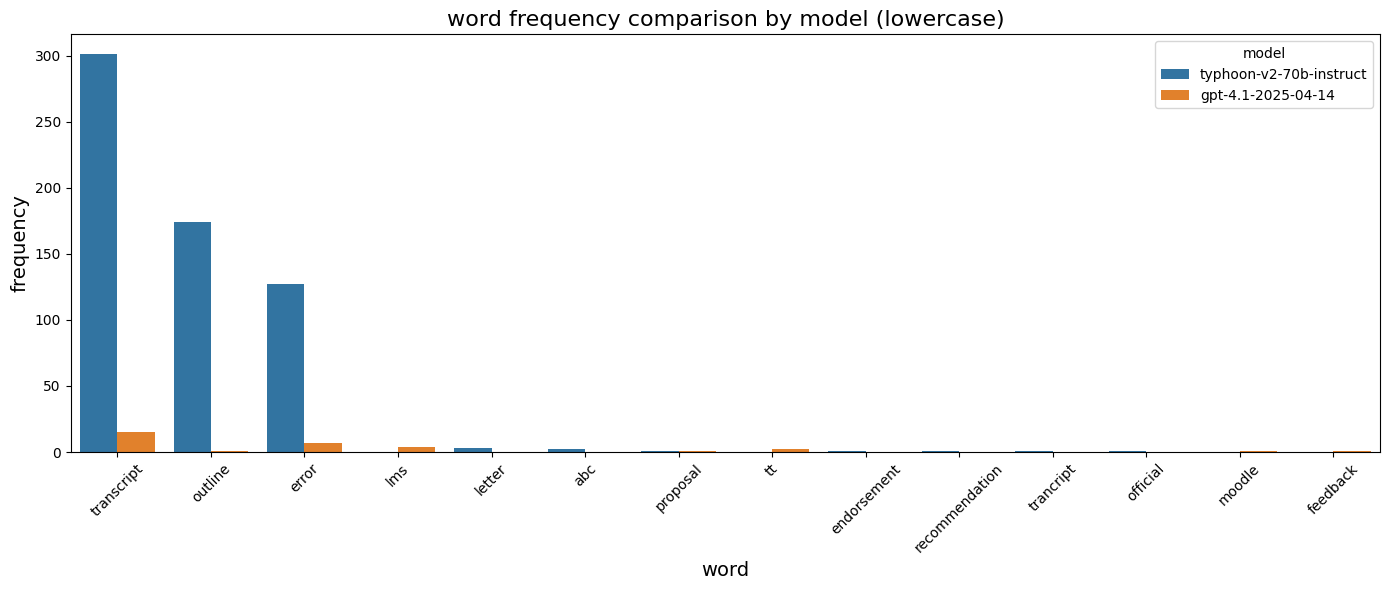

In [14]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def extract_english_words(text):
    return [w.lower() for w in re.findall(r'\b[a-zA-Z]+\b', str(text))]

ds["english_words"] = ds["output"].apply(extract_english_words)

model_names = ds["model"].unique()
model_counters = {}

for model in model_names:
    all_words = sum(ds[ds["model"] == model]["english_words"], [])
    word_freq = Counter(all_words)
    model_counters[model] = word_freq

all_words_combined = sum(model_counters.values(), Counter())
top_20_words = [word for word, _ in all_words_combined.most_common(20)]

plot_data = []

for word in top_20_words:
    for model in model_names:
        freq = model_counters[model][word]
        plot_data.append({
            "word": word.lower(),
            "model": model.lower(),
            "frequency": freq
        })

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(14, 6))
sns.barplot(data=plot_df, x="word", y="frequency", hue="model")
plt.title("word frequency comparison by model (lowercase)", fontsize=16)
plt.xlabel("word", fontsize=14)
plt.ylabel("frequency", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="model")
plt.tight_layout()
plt.show()


In [33]:
contain = ds[ds["output"].str.contains("abc", case=False, na=False)]

for i, row in contain.iterrows():
    print(f"ข้อความเต็ม: {row['output']}")


ข้อความเต็ม: หม่อมฉันขอพระราชทานวุฒิบัตรประจำปีการศึกษา 2566 ด้วยความเคารพอย่างสูง ข้าพเจ้าได้สำเร็จการศึกษาด้วยคะแนนเฉลี่ยสะสม 3.5 และได้ผ่านการฝึกงานที่บริษัท ABC จำกัด เป็นระยะเวลา 3 เดือน ข้าพเจ้าขอพระราชทานวุฒิบัตรเพื่อใช้เป็นเอกสารประกอบการสมัครงานในอนาคต ข้าพเจ้าขอขอบพระคุณในความกรุณาที่ได้พระราชทานวุฒิบัตรให้แก่ข้าพเจ้าด้วยความเคารพอย่างสูง
ข้อความเต็ม: เรียนอาจารย์ ผู้จัดทำขอเรียนแจ้งว่าได้ปฏิบัติงานฝึกงานที่บริษัท ABC จำกัด ตั้งแต่วันที่ 1 มกราคม ถึงวันที่ 31 มีนาคม 2566 โดยได้รับมอบหมายให้ทำงานในตำแหน่งผู้ช่วยฝ่ายการตลาด ซึ่งได้ปฏิบัติงานอย่างเต็มที่และได้รับการประเมินผลการปฏิบัติงานเป็นที่น่าพอใจ ผู้จัดทำจึงขอความกรุณาอาจารย์ลงนามรับรองการฝึกงานดังกล่าว เพื่อใช้เป็นเอกสารประกอบการสมัครงานในอนาคต ขอขอบพระคุณเป็นอย่างสูง


In [9]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

font_path = "thsarabunnew-webfont.ttf"
fm.fontManager.addfont(font_path)  # เพิ่มฟอนต์เข้า font manager
plt.rcParams["font.family"] = "TH Sarabun New"
mpl.rcParams['axes.unicode_minus'] = False  # ให้แสดงเครื่องหมายลบได้ถูกต้อง



 label: พิธีการ


<ipython-input-11-d22ea9afd82b>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="Blues_r")


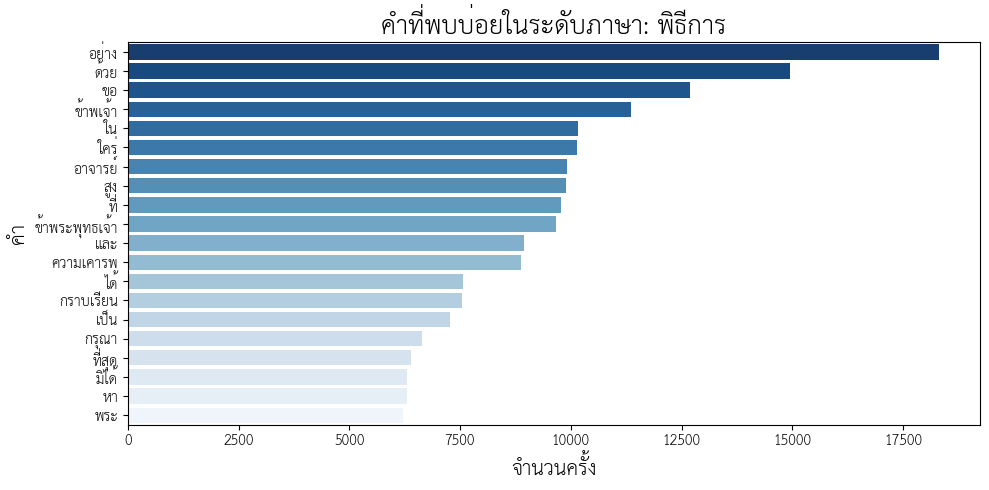


 label: ทางการ


<ipython-input-11-d22ea9afd82b>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="Blues_r")


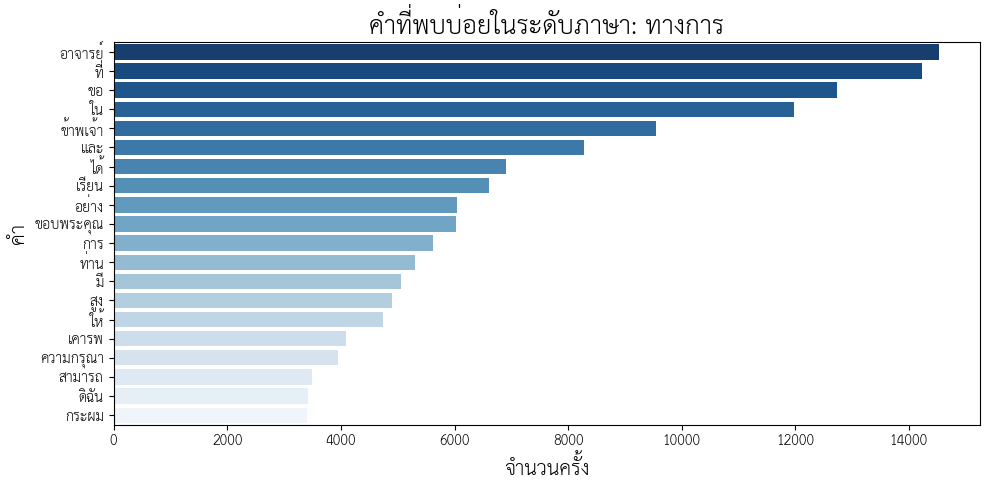


 label: กึ่งทางการ


<ipython-input-11-d22ea9afd82b>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="Blues_r")


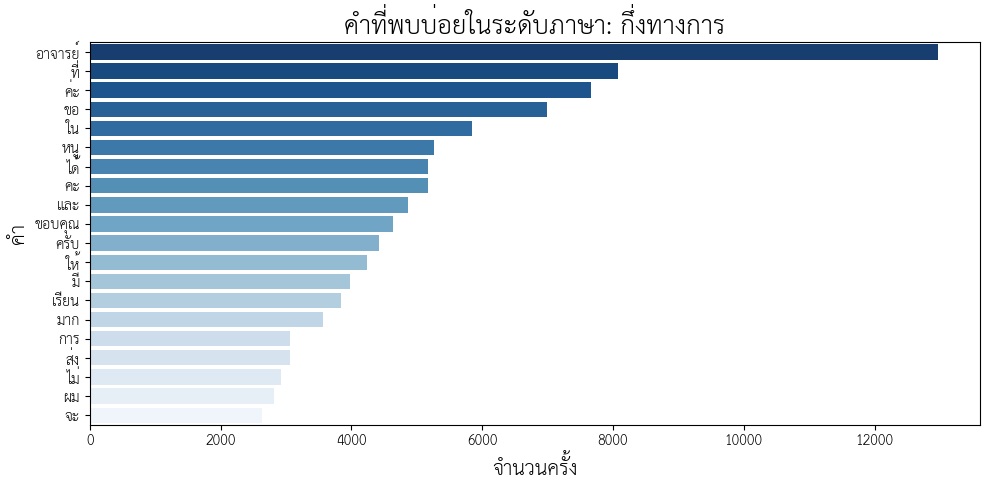


 label: ไม่เป็นทางการ


<ipython-input-11-d22ea9afd82b>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="Blues_r")


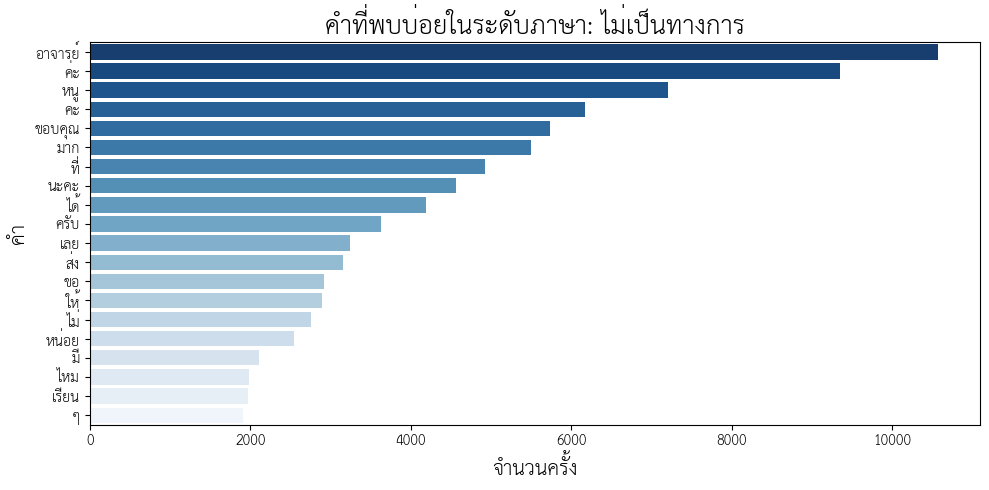


 label: กันเอง


<ipython-input-11-d22ea9afd82b>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="Blues_r")


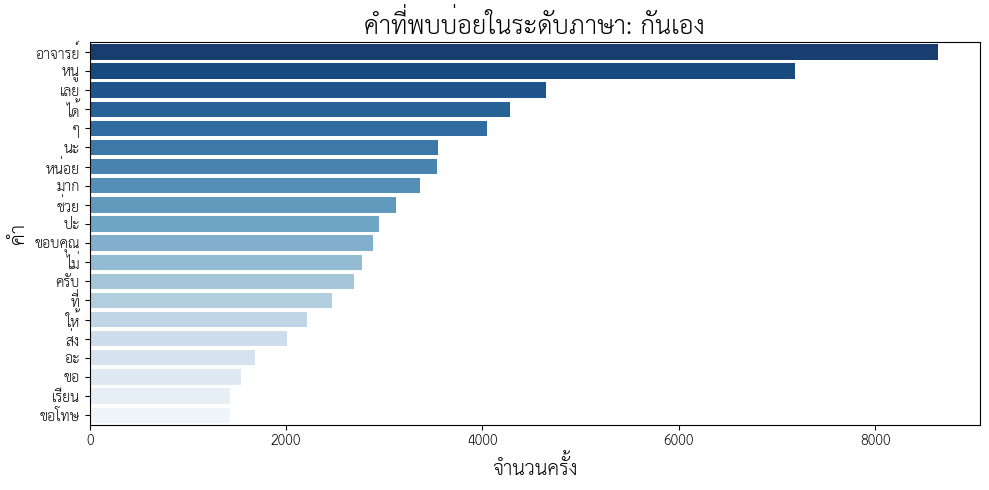

In [11]:
from pythainlp.tokenize import word_tokenize
from collections import Counter
import seaborn as sns

labels = ds["label"].unique()

for label in labels:
    print(f"\n label: {label}")

    texts = ds[ds["label"] == label]["output"].astype(str).tolist()
    all_text = " ".join(texts)

    words = word_tokenize(all_text, engine="newmm")
    words = [w for w in words if w.strip()]

    word_freq = Counter(words)
    top_words = word_freq.most_common(20)

    words, freqs = zip(*top_words)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(freqs), y=list(words), palette="Blues_r")
    plt.title(f"คำที่พบบ่อยในระดับภาษา: {label}", fontsize=18)
    plt.xlabel("จำนวนครั้ง", fontsize=14)
    plt.ylabel("คำ", fontsize=14)
    plt.tight_layout()
    plt.show()
